In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
from cv2 import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imutils
from imutils.contours import sort_contours
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#hyperparameters
batch_size = 64
learning_rate = 1e-3
img_height = 32
img_width = 32

In [3]:
# load and iterate training dataset
trainData = keras.preprocessing.image_dataset_from_directory(
    directory= './data/Chars74k/GoodImag',
    labels= 'inferred',
    label_mode= 'categorical',
    batch_size= batch_size,
    image_size= (img_height, img_width),
    color_mode='grayscale',
    validation_split= 0.2,
    subset= 'training',
    seed=123,
    )

testData = tf.keras.preprocessing.image_dataset_from_directory(
    directory= './data/Chars74k/GoodImag',
    labels= 'inferred',
    label_mode= 'categorical',
    batch_size= batch_size,
    image_size= (img_height, img_width),
    color_mode='grayscale',
    validation_split= 0.2,
    subset= 'validation',
    seed=123
    )

Found 7705 files belonging to 62 classes.
Using 6164 files for training.
Found 7705 files belonging to 62 classes.
Using 1541 files for validation.


In [4]:
class_names = trainData.class_names
class_names =  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
print(f"Data set's class names: \n {class_names}")
num_class = len(class_names)
print(f"Class count: {num_class}")

for image_batch, labels_batch in trainData:
  print("image_batch.shape >>",image_batch.shape)
  print("image_labels.shape >>",labels_batch.shape)
  break

Data set's class names: 
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Class count: 62
image_batch.shape >> (64, 32, 32, 1)
image_labels.shape >> (64, 62)


In [5]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

trainData = trainData.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(trainData))
# Notice the pixels values are now in `[0,1]`.


testData = testData.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(testData))

first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.18103172 0.7724725


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

trainData = trainData.cache().prefetch(buffer_size=AUTOTUNE)
testData = testData.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
model = tf.keras.Sequential([
    layers.Conv2D(64, (7,7), use_bias=False, input_shape=(img_width,img_height,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3,3),padding='same'),
    layers.Conv2D(128, (3,3), use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(padding='same'),    
    layers.GlobalAveragePooling2D(),
    #layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    #layers.Dense(256, activation='relu'),
    layers.Dense(num_class, activation='softmax')
])

In [10]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=600,
    restore_best_weights=True
    )

model.compile(
  optimizer= Adam(learning_rate=learning_rate),
  loss='categorical_crossentropy',
  metrics=['accuracy']
  )

In [11]:
with tf.device('/GPU:0'):
    history = model.fit(
        trainData,
        epochs=600,
        callbacks = [callback],
        validation_data=(testData)
       )

7132
Epoch 462/600
97/97 [==============================] - 1s 10ms/step - loss: 0.2483 - accuracy: 0.9240 - val_loss: 1.3273 - val_accuracy: 0.7618
Epoch 463/600
97/97 [==============================] - 1s 10ms/step - loss: 0.2349 - accuracy: 0.9341 - val_loss: 1.2479 - val_accuracy: 0.7670
Epoch 464/600
97/97 [==============================] - 1s 10ms/step - loss: 0.2278 - accuracy: 0.9341 - val_loss: 1.2786 - val_accuracy: 0.7722
Epoch 465/600
97/97 [==============================] - 1s 10ms/step - loss: 0.2279 - accuracy: 0.9272 - val_loss: 1.2124 - val_accuracy: 0.7696
Epoch 466/600
97/97 [==============================] - 1s 11ms/step - loss: 0.2315 - accuracy: 0.9313 - val_loss: 1.3453 - val_accuracy: 0.7605
Epoch 467/600
97/97 [==============================] - 1s 11ms/step - loss: 0.2183 - accuracy: 0.9361 - val_loss: 1.5902 - val_accuracy: 0.7229
Epoch 468/600
97/97 [==============================] - 1s 11ms/step - loss: 0.2533 - accuracy: 0.9243 - val_loss: 1.2985 - val_accu

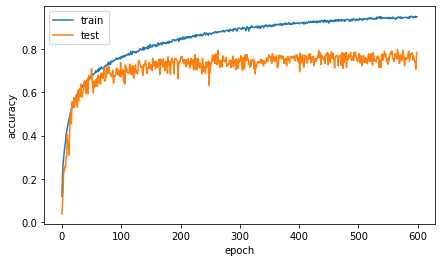

In [12]:
plt.figure(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [13]:
y_pred = model.predict(testData)

predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = tf.concat([y for x, y in testData], axis=0)
true_categories = tf.argmax(true_categories, axis=1)

report = classification_report(true_categories, predicted_categories, target_names= class_names, output_dict=True)
print(pd.DataFrame(report).transpose())

              precision    recall  f1-score      support
0              0.733333  0.407407  0.523810    27.000000
1              0.900000  0.818182  0.857143    11.000000
2              0.600000  0.600000  0.600000    10.000000
3              0.916667  0.846154  0.880000    13.000000
4              0.307692  0.666667  0.421053     6.000000
...                 ...       ...       ...          ...
y              0.800000  0.444444  0.571429     9.000000
z              0.500000  0.166667  0.250000     6.000000
accuracy       0.783258  0.783258  0.783258     0.783258
macro avg      0.732063  0.684353  0.677853  1541.000000
weighted avg   0.799300  0.783258  0.775694  1541.000000

[65 rows x 4 columns]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(true_categories, predicted_categories)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(true_categories, predicted_categories, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(true_categories, predicted_categories, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(true_categories, predicted_categories, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.783258
Precision: 0.732063
Recall: 0.684353
F1 score: 0.677853
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
